In [88]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import causallearn

from causallearn.utils.cit import *
from causallearn.graph.GraphClass import CausalGraph
import pandas as pd
from itertools import combinations, permutations
from numpy import ndarray
from typing import Dict, List, Tuple
from causallearn.utils.cit import fisherz
import random
import itertools

import time

import scipy as sp
from scipy.stats import beta

from statsmodels.distributions.empirical_distribution import ECDF


# Traffic Model:

## Null hypothesis $H_0$: Accidents happen independently of traffic load

In [162]:
# # Number of days:
# N = 365 * 10
# # Number of discretized steps:
# # If each timestep represents 10 mins, then T = 108 would represent 18 hours.
# T = 108

# p_acc = 0.001
# x_eq = 100
# mu = 0.2
# mu_acc = 0.02
# time_duration_acc = 2
# noise_range = 10
# ctrl = mu * x_eq

# T_acc_vec = np.random.geometric(p = p_acc, size = N)
# noise_array = np.random.rand(N, T) * 2 * noise_range - noise_range
# x_array_H0 = np.zeros((N, T))
# x_0 = np.random.rand(N) * 2 * noise_range - noise_range + x_eq

# x_array_H0[:, 0] = x_0
# for t in range(T-1):
#     x_array_H0[:, t+1] = (1-mu) * x_array_H0[:, t] + ctrl + noise_array[:, t]

# # Changing load due to dynamics:
# # for i in range(N):
# #     if T_acc_vec[i] < T:
# #         for k in range(T_acc_vec[i], min(T, T_acc_vec[i] + time_duration_acc)):


In [320]:
# Number of days:
N = 365 * 20
# Number of discretized steps:
# If each timestep represents 10 mins, then T = 108 would represent 18 hours.
T = 108

In [321]:
start_time = time.time()

x_eq = 100
mu = 0.3
mu_acc = 0.2
time_duration_acc = 2
noise_range = 10
ctrl = mu * x_eq

noise_array = np.random.rand(N, T) * 2 * noise_range - noise_range
x_array_H0 = np.zeros((N, T))
# x_0 = np.random.rand(N) * 2 * noise_range - noise_range + 0.5 * x_eq
x_0 = np.random.rand(N) * 2 * noise_range - noise_range + 1 * x_eq

p_acc = 0.06
acc_vec = np.random.binomial(1, p = p_acc, size = (N, T))
acc_vec_high_load = np.random.binomial(1, p = p_acc_high_load, size = (N, T))
acc_realized_H0 = np.zeros((N, T))

high_load_threshold_ratio = 0.9
high_load_threshold = x_eq + high_load_threshold_ratio * noise_range
counter = 0

x_array_H0[:, 0] = x_0
for i in range(N):
    for t in range(T-1):
        if t == 0:
            acc_realized_H0[i, t] = 0 
            x_array_H0[i, t+1] = (1 - mu) * x_array_H0[i, t] + ctrl + noise_array[i, t]
            counter = 0
        elif counter >= 1 and counter < time_duration_acc:
            acc_realized_H0[i, t] = 1
            x_array_H0[i, t+1] = (1 - mu_acc) * x_array_H0[i, t] + ctrl + noise_array[i, t]
            counter += 1
        elif acc_vec[i, t] == 1:
            acc_realized_H0[i, t] = 1
            x_array_H0[i, t+1] = (1 - mu_acc) * x_array_H0[i, t] + ctrl + noise_array[i, t]
            counter = 1
        else:
            acc_realized_H0[i, t] = 0
            x_array_H0[i, t+1] = (1 - mu) * x_array_H0[i, t] + ctrl + noise_array[i, t]
            counter = 0

# Changing load due to dynamics:
# for i in range(N):
#     if T_acc_vec[i] < T:
#         for k in range(T_acc_vec[i], min(T, T_acc_vec[i] + time_duration_acc)):

end_time = time.time()

print("Time: ", end_time - start_time)



Time:  1.0548689365386963


## Alternative hypothesis $H_1$: Accidents are made more likely by high traffic load

In [322]:
start_time = time.time()


x_eq = 100
mu = 0.3
mu_acc = 0.2
time_duration_acc = 2
noise_range = 10
ctrl = mu * x_eq

noise_array = np.random.rand(N, T) * 2 * noise_range - noise_range
x_array_H1 = np.zeros((N, T))
# x_0 = np.random.rand(N) * 2 * noise_range - noise_range + 0.5 * x_eq
x_0 = np.random.rand(N) * 2 * noise_range - noise_range + 1 * x_eq

p_acc = 0.03
p_acc_high_load = 0.3
acc_vec = np.random.binomial(1, p = p_acc, size = (N, T))
acc_vec_high_load = np.random.binomial(1, p = p_acc_high_load, size = (N, T))
acc_realized_H1 = np.zeros((N, T))

high_load_threshold_ratio = 0.9
high_load_threshold = x_eq + high_load_threshold_ratio * noise_range
counter = 0

x_array_H1[:, 0] = x_0
for i in range(N):
    for t in range(T-1):
        if t == 0:
            acc_realized_H1[i, t] = 0 
            x_array_H1[i, t+1] = (1 - mu) * x_array_H1[i, t] + ctrl + noise_array[i, t]
            counter = 0
        elif counter >= 1 and counter < time_duration_acc:
#         if counter >= 1 and counter < time_duration_acc:
            acc_realized_H1[i, t] = 1
            x_array_H1[i, t+1] = (1 - mu_acc) * x_array_H1[i, t] + ctrl + noise_array[i, t]
            counter += 1
        elif x_array_H1[i, t] <= high_load_threshold and acc_vec[i, t] == 1:
            acc_realized_H1[i, t] = 1
            x_array_H1[i, t+1] = (1 - mu_acc) * x_array_H1[i, t] + ctrl + noise_array[i, t]
            counter = 1
        elif x_array_H1[i, t] > high_load_threshold and acc_vec_high_load[i, t] == 1:
            acc_realized_H1[i, t] = 1
            x_array_H1[i, t+1] = (1 - mu_acc) * x_array_H1[i, t] + ctrl + noise_array[i, t]
            counter = 1
        else:
            acc_realized_H1[i, t] = 0
            x_array_H1[i, t+1] = (1 - mu) * x_array_H1[i, t] + ctrl + noise_array[i, t]
            counter = 0

# Changing load due to dynamics:
# for i in range(N):
#     if T_acc_vec[i] < T:
#         for k in range(T_acc_vec[i], min(T, T_acc_vec[i] + time_duration_acc)):


end_time = time.time()

print("Time: ", end_time - start_time)



Time:  1.326430082321167


In [323]:
x_array_H1.shape

(7300, 108)

In [324]:
## Re-sort the data:

# x_array.shape
# acc_realized.shape

def generate_data_processed_dict(x_array, acc_realized):
    
    assert x_array.shape == acc_realized.shape
    N = x_array.shape[0]
    T = x_array.shape[1]
    
    first_times_of_rare_event = np.zeros(N)
    for i in range(N):
    #     print(acc_realized[i, :].shape)
    #     print(np.zeros(T).shape)
        if (acc_realized[i, :] == np.zeros(T)).all():
            first_times_of_rare_event[i] = -1
        else:
    #         print(min([t for t in range(T) if acc_realized[i, t] == 1]))
            first_times_of_rare_event[i] = min([t for t in range(T) if acc_realized[i, t] == 1])
#             print("i:", i)
#             print("first_times_of_rare_event[i]:", first_times_of_rare_event[i])

    first_times_of_rare_event_as_set = set(list(first_times_of_rare_event))
    first_times_of_rare_event_as_set.remove(-1)
    first_times_of_rare_event_as_list = list(first_times_of_rare_event_as_set)

    # for first_time in first_times_of_rare_event_as_set:

    # first_times_of_rare_event_as_set

    x_processed_dict_XT = {}
    x_processed_dict_Xgen = {}
    first_times_dict = {}
    
    for time in first_times_of_rare_event_as_list:
    #     print(time
        x_processed_dict_XT[time] = []
        x_processed_dict_Xgen[time] = []
        first_times_dict[time] = []
        for i in range(N):
            if first_times_of_rare_event[i] >= time:
                x_processed_dict_Xgen[time].append(x_array[i, int(time)-1])
            if first_times_of_rare_event[i] == time:
                first_times_dict[time].append(i)
                x_processed_dict_XT[time].append(x_array[i, int(time)-1])
    
    x_values_jumps_XT = list(itertools.chain(*list(x_processed_dict_XT.values())))
    assert len(x_values_jumps_XT) <= N
    
    return x_processed_dict_XT, x_processed_dict_Xgen, first_times_dict

def generate_cdf_Xgen(x_processed_dict_Xgen, first_times_dict, N, T,\
                      x_lower_bound = 50.0, x_upper_bound = 200.0, x_values_length = 5000):
    assert list(x_processed_dict_Xgen.keys()) == list(first_times_dict.keys())
    
    x_values_jumps_Xgen = sorted(list(itertools.chain(*list(x_processed_dict_Xgen.values()))))
    print("len(x_values_jumps_Xgen):", len(x_values_jumps_Xgen))
    print("max(x_values_jumps_Xgen):", max(x_values_jumps_Xgen))
#     return
    
#     cdf_value_at_jumps_Xgen = []
    x_cdf_dict_Xgen = {}
    
#     for count_1, x_value in enumerate(x_values_jumps_Xgen):
    for count_1, x_value in enumerate(np.linspace(x_lower_bound, x_upper_bound, x_values_length)):
#         if count_1 % 100 == 0:
#             print(count_1)
        cdf_value_temp = 0
        for count_2, time in enumerate(first_times_dict.keys()):
#             print(count_2)
            cdf_value_temp += len([x_val for x_val in x_processed_dict_Xgen[time] if x_val <= x_value])/len(x_processed_dict_Xgen[time]) \
                                * len(first_times_dict[time])/N
#         cdf_value_at_jumps_Xgen.append(cdf_value_temp)
        x_cdf_dict_Xgen[x_value] = cdf_value_temp
    
    # INCOMPLETE; make dictionary.
    
    return x_values_jumps_Xgen, x_cdf_dict_Xgen


def generate_cdf_XT(x_processed_dict_XT, first_times_dict, N, T):
    assert list(x_processed_dict_XT.keys()) == list(first_times_dict.keys())
    
    x_values_jumps_XT = sorted(list(itertools.chain(*list(x_processed_dict_XT.values()))))
    x_cdf_dict_XT = {}
    
    # Sort x_values_jumps_XT
    assert len(x_values_jumps_XT) <= N
    
    print("len(x_values_jumps_XT):", len(x_values_jumps_XT))
    print("max(x_values_jumps_XT):", max(x_values_jumps_XT))
        
    cdf_value_at_jumps_XT = []
    for x_value in x_values_jumps_XT:
        cdf_value_temp = len([x_val for x_val in x_values_jumps_XT if x_val <= x_value]) \
                                     / len(x_values_jumps_XT)
        cdf_value_at_jumps_XT.append(cdf_value_temp)
        x_cdf_dict_XT[x_value] = cdf_value_temp
        
    cdf_evenly_spaced = np.linspace(1/len(cdf_value_at_jumps_XT), 1, len(cdf_value_at_jumps_XT))
        
#     print("cdf_value_at_jumps_XT:", cdf_value_at_jumps_XT[0:10])
#     print("cdf_evenly_spaced:", cdf_evenly_spaced[0:10])
#     print("1/len(cdf_value_at_jumps_XT):", 1/len(cdf_value_at_jumps_XT))
#     print("cdf_value_at_jumps_XT - cdf_evenly_spaced:", cdf_value_at_jumps_XT - cdf_evenly_spaced)


    # Assertion: Sanity check on cdf_value_at_jumps_XT
    assert np.linalg.norm(np.array(cdf_value_at_jumps_XT) - np.array(cdf_evenly_spaced)) <= 0.0001
    
    # INCOMPLETE; make dictionary.
    return x_values_jumps_XT, x_cdf_dict_XT

def cdf_value(x, x_cdf_dict):
    key_list = [x_val for x_val in x_cdf_dict.keys() if x_val <= x]
    if key_list != []:
        dict_key = max(key_list)
    else:
        dict_key = min(x_cdf_dict.keys())
    return x_cdf_dict[dict_key]

def compare_CDFs(x_cdf_dict_1, x_cdf_dict_2, x_lower_bound = 50.0, x_upper_bound = 200.0, x_values_length = 2000):
    error_list = []
    for x_value in np.linspace(x_lower_bound, x_upper_bound, x_values_length+1):
        error = abs(cdf_value(x_value, x_cdf_dict_1) - cdf_value(x_value, x_cdf_dict_2))
        error_list.append(error)
    
    return max(error_list)



In [325]:
# np.linspace(0, 1, 5)

In [326]:
begin_time = time.time()

x_processed_dict_H0_XT, x_processed_dict_H0_Xgen, first_times_dict_H0 = generate_data_processed_dict(x_array_H0, acc_realized_H0)
# print("x_processed_dict_H0_XT.values():", x_processed_dict_H0_XT.values())
# print(len(list(itertools.chain(*list(first_times_dict_H0.values()))))/N)

x_processed_dict_H1_XT, x_processed_dict_H1_Xgen, first_times_dict_H1 = generate_data_processed_dict(x_array_H1, acc_realized_H1)
# print(len(list(itertools.chain(*list(first_times_dict_H1.values()))))/N)

x_values_jumps_H0_XT, x_cdf_dict_H0_XT = generate_cdf_XT(x_processed_dict_H0_XT, first_times_dict_H0, N, T)
print()
x_values_jumps_H0_Xgen, x_cdf_dict_H0_Xgen = generate_cdf_Xgen(x_processed_dict_H0_Xgen, first_times_dict_H0, N, T)
print()

x_values_jumps_H1_XT, x_cdf_dict_H1_XT = generate_cdf_XT(x_processed_dict_H1_XT, first_times_dict_H1, N, T)
print()
x_values_jumps_H1_Xgen, x_cdf_dict_H1_Xgen = generate_cdf_Xgen(x_processed_dict_H1_Xgen, first_times_dict_H1, N, T)
print()

end_time = time.time()
print("Time:", end_time - begin_time)




len(x_values_jumps_XT): 7293
max(x_values_jumps_XT): 124.71626484171884

len(x_values_jumps_Xgen): 122481
max(x_values_jumps_Xgen): 125.86895187322497

len(x_values_jumps_XT): 7288
max(x_values_jumps_XT): 124.98344569519402

len(x_values_jumps_Xgen): 120747
max(x_values_jumps_Xgen): 124.98344569519402

Time: 79.93391990661621


In [327]:
# Compare CDFs for both the H0 and H1 cases.

plot_x_range = np.linspace(x_lower_bound, x_upper_bound, x_values_length+1)

print(compare_CDFs(x_cdf_dict_H0_XT, x_cdf_dict_H0_Xgen))
print(compare_CDFs(x_cdf_dict_H1_XT, x_cdf_dict_H1_Xgen))



0.009626224614832535
0.2784805150198752


In [328]:
def generate_aligned_cdf_dict(x_cdf_dict, plot_x_range):
    aligned_cdf_dict = {}
    aligned_cdf_values = []
    for x_value in plot_x_range:
        cdf_value_temp = cdf_value(x_value, x_cdf_dict)
        aligned_cdf_dict[x_value] = cdf_value_temp
        aligned_cdf_values.append(cdf_value_temp)
    
    return aligned_cdf_dict, np.array(aligned_cdf_values)
    

(1001,)
(1001,)


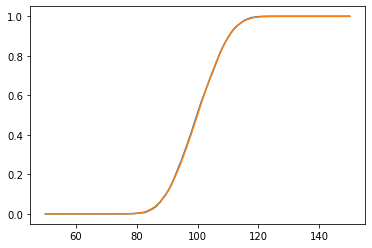

In [329]:
x_lower_bound = 50
x_upper_bound = 150
x_values_length = 1000

plot_x_range = np.linspace(x_lower_bound, x_upper_bound, x_values_length+1)
_, x_cdf_values_H0_XT_aligned = generate_aligned_cdf_dict(x_cdf_dict_H0_XT, plot_x_range)
_, x_cdf_values_H0_Xgen_aligned = generate_aligned_cdf_dict(x_cdf_dict_H0_Xgen, plot_x_range)

# print(x_cdf_dict_H0_Xgen_aligned)
print(x_cdf_values_H0_XT_aligned.shape)
print(plot_x_range.shape)


plt.plot(plot_x_range, x_cdf_values_H0_XT_aligned)
plt.plot(plot_x_range, x_cdf_values_H0_Xgen_aligned)

(1001,)
(1001,)


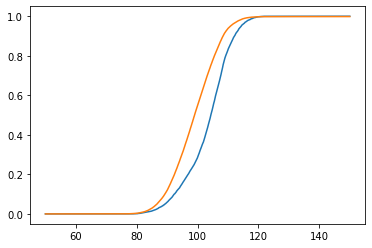

In [330]:
x_lower_bound = 50
x_upper_bound = 150
x_values_length = 1000

plot_x_range = np.linspace(x_lower_bound, x_upper_bound, x_values_length+1)
_, x_cdf_values_H1_XT_aligned = generate_aligned_cdf_dict(x_cdf_dict_H1_XT, plot_x_range)
_, x_cdf_values_H1_Xgen_aligned = generate_aligned_cdf_dict(x_cdf_dict_H1_Xgen, plot_x_range)

# print(x_cdf_dict_H0_Xgen_aligned)
print(x_cdf_values_H1_XT_aligned.shape)
print(plot_x_range.shape)

plt.plot(plot_x_range, x_cdf_values_H1_XT_aligned)
plt.plot(plot_x_range, x_cdf_values_H1_Xgen_aligned)

In [1]:
# begin_time = time.time()

# x_processed_dict_H1, first_times_dict_H1 = generate_data_processed_dict(x_array_H1, acc_realized_H1)

# # print(x_processed_dict_H1.keys())
# # print()
# # print(first_times_dict_H1.keys())

# # x_processed_dict_H1
# # x_values_jumps_H1 = list(itertools.chain(*list(x_processed_dict_H1.values())))


# print(x_processed_dict_H1.keys())
# print()
# print(first_times_dict_H1.keys())
# print()


# x_values_jumps_H1, cdf_value_at_jumps_H1 = generate_cdf_Xgen(x_processed_dict_H1, first_times_dict_H1, N, T)

# # print(len(list(itertools.chain(*list(first_times_dict_H1.values())))))

# # end_time = time.time()

# # print("\nTotal time:", end_time - begin_time)




In [3]:
# cdf_value_at_jumps_H1[-1]

# Scratch Work